In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from pathlib import Path
from dataclasses import dataclass, field

pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 200)

# Load data


In [2]:
USE_MONTHLY_PRICES = True
# USE_MONTHLY_PRICES = False

In [3]:
def is_sorted(values: np.ndarray | pd.Series):
    return np.all(np.sort(values) == values)


day_close_folder = Path('../data/day_close/')
assert day_close_folder.exists()
tickers_original = sorted([file.removesuffix('.csv') for file in os.listdir(day_close_folder)])
print(f'Number of tickers: {len(tickers_original)}')

dfs_original = {ticker: pd.read_csv(day_close_folder / f'{ticker}.csv', parse_dates=['TRADEDATE']).dropna() for ticker in tickers_original}
assert len(dfs_original) == len(tickers_original)
for df in dfs_original.values():
    assert np.all(next(iter(dfs_original.values())).columns == df.columns)
    assert len(df['TRADEDATE']) == len(df['TRADEDATE'].drop_duplicates())
    assert is_sorted(df['TRADEDATE'])
    assert np.all(df['BOARDID'] == 'TQBR')

Number of tickers: 244


# Filter N stocks with the earliest start date


In [4]:
def is_earlier(df: pd.DataFrame, date: datetime.date) -> bool:
    return df.iloc[0]['TRADEDATE'] <= pd.to_datetime(date)


def filter_dfs(dfs: dict[str, pd.DataFrame], n_target_stocks: int, remove_tickers: list[str]) -> dict[str, pd.DataFrame]:
    # search for common starting date for n_target_stocks
    day = datetime.timedelta(days=1)
    left = datetime.date(1990, 1, 1)
    right = datetime.date.today()
    filtered_tickers = list(dfs.keys())
    # (left, right]
    while left + day != right:
        middle = left + (right - left) // 2
        is_good = [is_earlier(dfs[ticker], middle) for ticker in filtered_tickers]
        if sum(is_good) >= n_target_stocks:
            filtered_tickers = [ticker for i, ticker in enumerate(filtered_tickers) if is_good[i]]
            right = middle
        else:
            left = middle

    # drop remove_tickers
    assert len(filtered_tickers) >= n_target_stocks
    if len(filtered_tickers) > n_target_stocks:
        assert sum([is_earlier(dfs[ticker], left) for ticker in filtered_tickers]) < n_target_stocks
        assert sum([is_earlier(dfs[ticker], right) for ticker in filtered_tickers]) >= n_target_stocks
        assert remove_tickers
    print(f'Drop tickers: {[ticker for ticker in filtered_tickers if ticker in remove_tickers]}')

    filtered_tickers = [ticker for ticker in filtered_tickers if ticker not in remove_tickers]
    assert len(filtered_tickers) == n_target_stocks - len(remove_tickers)
    return {ticker: dfs[ticker].copy() for ticker in filtered_tickers}


N_TARGET_STOCKS = 31
REMOVE_TICKERS = ['IRAO']

# N_TARGET_STOCKS = 5
# REMOVE_TICKERS = ['HYDR']

dfs = filter_dfs(dfs_original, n_target_stocks=N_TARGET_STOCKS, remove_tickers=REMOVE_TICKERS)
tickers = list(dfs.keys())
print(f'Number of stocks: {len(dfs)}')
print(f'Stocks: {list(dfs.keys())}')

Drop tickers: ['IRAO']
Number of stocks: 30
Stocks: ['AFLT', 'ALRS', 'GCHE', 'HYDR', 'LKOH', 'LSRG', 'MGNT', 'MOEX', 'MRKC', 'MRKP', 'MSNG', 'MSRS', 'MTLR', 'MTLRP', 'MTSS', 'NVTK', 'PHOR', 'PIKK', 'POLY', 'RTKM', 'RTKMP', 'SBER', 'SBERP', 'TATN', 'TATNP', 'TGKA', 'TRMK', 'TRNFP', 'UTAR', 'VTBR']


From 2013-12-16 to 2023-03-28


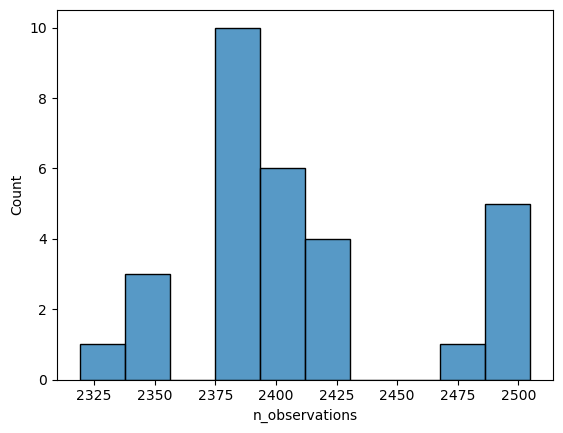

In [5]:
start_date = max(map(lambda df: df.iloc[0]['TRADEDATE'], dfs.values()))
finish_date = min(map(lambda df: df.iloc[-1]['TRADEDATE'], dfs.values()))
print(f'From {start_date.strftime("%Y-%m-%d")} to {finish_date.strftime("%Y-%m-%d")}')
sns.histplot([df.shape[0] for df in dfs.values()])
plt.xlabel('n_observations')
plt.show()

# Merge DataFrames with common dates adn remove old dates with small number of observations


DataFrame size after merge: 2226


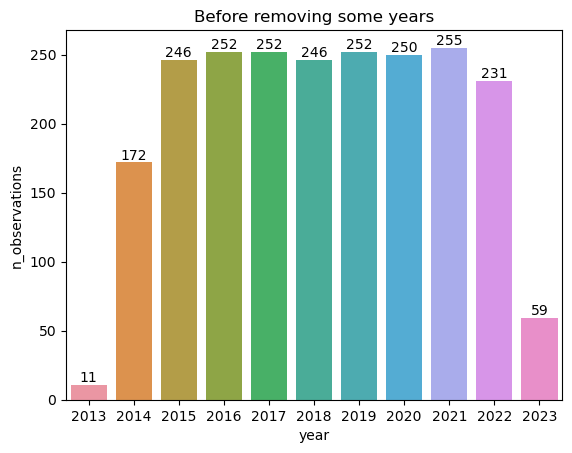

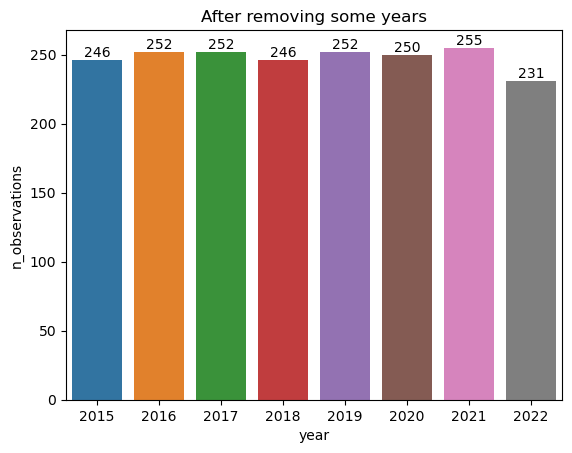

In [6]:
def merge_dfs(dfs: dict[str, pd.DataFrame], date_column, price_column: str):
    result_df = None
    for ticker, df in dfs.items():
        df = df.copy().set_index(date_column)
        if result_df is None:
            result_df = df[[price_column]]
            result_df.columns = [ticker]
        else:
            result_df = result_df.join(df[[price_column]].rename(columns={'CLOSE': ticker}))
    return result_df


def plot_observations_by_year(df_price):
    n_observations_by_years = df_price.index.year.value_counts().sort_index()
    ax = sns.barplot(y=n_observations_by_years, x=n_observations_by_years.index)
    ax.bar_label(ax.containers[0])
    plt.ylabel('n_observations')
    plt.xlabel('year')
    plt.show()


df_price = merge_dfs(dfs, date_column='TRADEDATE', price_column='CLOSE').dropna()
assert len(df_price.columns) == len(dfs)
print(f'DataFrame size after merge: {len(df_price)}')

plt.title('Before removing some years')
plot_observations_by_year(df_price)

n_observations_by_years = df_price.index.year.value_counts()
n_observations_by_years = n_observations_by_years[n_observations_by_years >= 230]
df_price = df_price[df_price.index.year.isin(n_observations_by_years.index)]

plt.title('After removing some years')
plot_observations_by_year(df_price)

# Compute monthly returns


In [7]:
def compute_mopnthly_prices(df_price):
    return df_price.resample('MS').first()


if USE_MONTHLY_PRICES:
    df_price = compute_mopnthly_prices(df_price)

TRADING_DAYS_IN_YEAR = df_price.index.year.value_counts()[:-2].mean()
print(f'Number of trading days in a year: {TRADING_DAYS_IN_YEAR:.3f}')

Number of trading days in a year: 12.000


# Train test split


In [8]:
from sklearn.model_selection import train_test_split


TEST_RATIO = 0.5

df_price_train, df_price_test = train_test_split(df_price, test_size=TEST_RATIO, shuffle=False)
assert is_sorted(df_price_train.index) and is_sorted(df_price_test.index)
assert df_price_test.index[0] > df_price_train.index[-1]

print(f'Train size: {len(df_price_train)}. Test size: {len(df_price_test)}. Test ratio: {len(df_price_test) / (len(df_price_train) + len(df_price_test))}')

Train size: 48. Test size: 48. Test ratio: 0.5


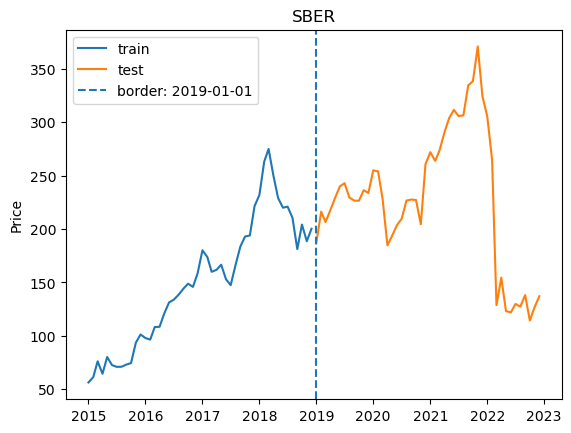

In [9]:
def plot_ticker(ticker: str, df_price_train, df_price_test):
    plt.plot(df_price_train[ticker], label='train')
    plt.plot(df_price_test[ticker], label='test')
    plt.axvline(df_price_test.index[0], linestyle='dashed', label=f'border: {df_price_test.index[0].strftime("%Y-%m-%d")}')
    plt.ylabel('Price')
    plt.title(ticker)
    plt.legend(loc='upper left')
    plt.show()


plot_ticker('SBER', df_price_train, df_price_test)

### Return and correlation/covariance matrix calculation


In [10]:
@dataclass
class Correlations:
    returns: pd.DataFrame
    cov: pd.DataFrame
    corr: pd.DataFrame
    index: list[str] = field(default_factory=list)

    def __post_init__(self):
        self.index = list(self.returns.columns)
        assert np.all(self.index == self.cov.columns)
        assert np.all(self.index == self.cov.index)
        assert np.all(self.index == self.corr.columns)
        assert np.all(self.index == self.corr.index)


def get_correlations(df_price) -> Correlations:
    df_returns = df_price.pct_change().dropna()  # p(t) / p(t - 1) - 1
    matrix_corr = df_returns.corr()
    matrix_cov = df_returns.cov()
    assert matrix_corr.shape == matrix_cov.shape == (df_returns.shape[1], df_returns.shape[1])
    return Correlations(returns=df_returns, cov=matrix_cov, corr=matrix_corr)

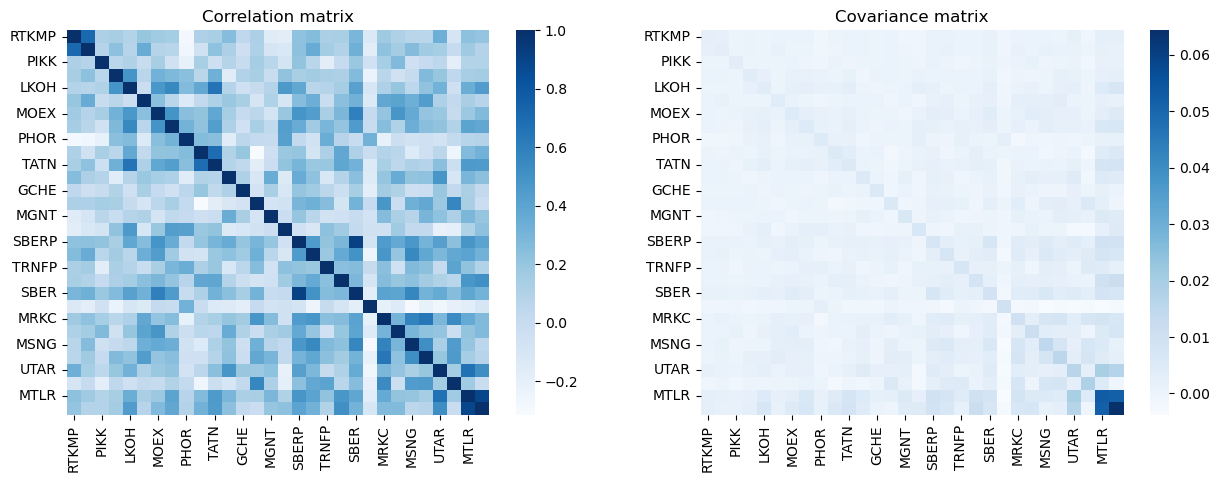

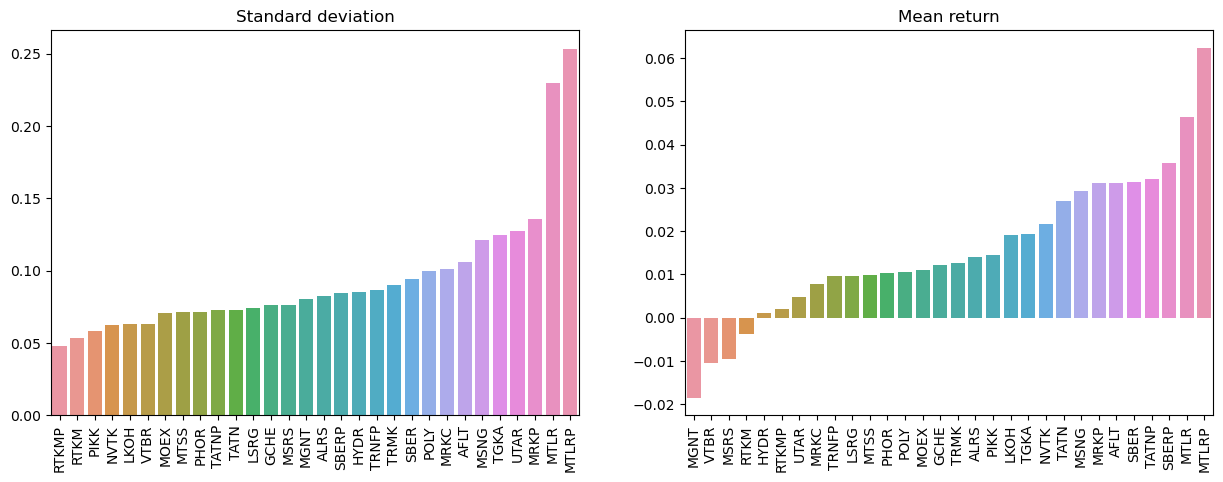

In [11]:
def plot_correlations(df_price):
    correlations = get_correlations(df_price)
    sorted_index = sorted(correlations.index, key=lambda x: correlations.cov[x][x])

    # Plot correlations
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    for matrix, title, ax in [(correlations.corr, 'Correlation', ax1), (correlations.cov, 'Covariance', ax2)]:
        sns.heatmap(matrix.loc[sorted_index, sorted_index], cmap='Blues', ax=ax)
        ax.set_title(f'{title} matrix')
    plt.show()

    # Plot mean return and its standard deviation
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(5)

    sns.barplot(x=sorted_index, y=np.sqrt(np.diagonal(correlations.cov.loc[sorted_index, sorted_index])), ax=ax1)
    ax1.set_title('Standard deviation')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

    sorted_index = sorted(correlations.index, key=lambda x: correlations.returns.mean(axis=0)[x])
    sns.barplot(x=sorted_index, y=correlations.returns[sorted_index].mean(axis=0), ax=ax2)
    ax2.set_title('Mean return')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

    plt.show()


plot_correlations(df_price_train)

### Compute portfolio stats


In [12]:
@dataclass
class PortfolioStats:
    df_price: pd.DataFrame

    portfolio_w: pd.Series
    portfolio_label: str

    # __post_init__ attributes

    correlations: Correlations = None

    baseline_w: pd.Series = None
    baseline_label: str = None

    portfolio_returns_pct: pd.Series = None
    baseline_returns_pct: pd.Series = None

    portfolio_mean: float = np.nan
    portfolio_std: float = np.nan
    portfolio_sharpe_ratio: float = np.nan

    baseline_mean: float = np.nan
    baseline_std: float = np.nan
    baseline_sharpe_ratio = np.nan

    difference_mean: float = np.nan
    difference_std: float = np.nan
    portfolio_information_ratio: float = np.nan

    def __post_init__(self):
        # compute correlations
        self.correlations = get_correlations(self.df_price)

        # get baseline portfolio allocation
        self.baseline_label, self.baseline_w = self.get_baseline()

        # compute returns in %
        self.portfolio_returns_pct = self._get_portfolio_returns_pct(self.portfolio_w)
        self.baseline_returns_pct = self._get_portfolio_returns_pct(self.baseline_w)

        # compute metrics
        self.portfolio_mean, self.portfolio_std, self.portfolio_sharpe_ratio = self._get_annual_mean_std_ratio(self.portfolio_returns_pct)
        self.baseline_mean, self.baseline_std, self.baseline_sharpe_ratio = self._get_annual_mean_std_ratio(self.baseline_returns_pct)
        self.difference_mean, self.difference_std, self.portfolio_information_ratio = self._get_annual_mean_std_ratio(self.portfolio_returns_pct - self.baseline_returns_pct)

    # Computation functions
    def _get_portfolio_returns_pct(self, w: pd.Series) -> pd.Series:
        assert self.correlations.returns.shape[1] == len(w)
        assert np.all(w.index == self.correlations.returns.columns)
        # at t we decide to allocate w rubles to each asset
        # then we get the return p(t + 1) / p(t) - 1
        portfolio_returns = self.correlations.returns @ w  # df_return is p(t) / p(t - 1) - 1
        return portfolio_returns * 100

    @staticmethod
    def _get_annual_mean_std_ratio(returns: pd.Series) -> tuple[float, float]:
        mean = returns.mean() * TRADING_DAYS_IN_YEAR
        std = returns.std() * np.sqrt(TRADING_DAYS_IN_YEAR)
        return mean, std, mean / std

    # Plot functions
    def plot_cumulative_return(self, color: str, baseline: bool, plot_label: bool):
        plt.gcf().set_figwidth(15)
        plt.gcf().set_figheight(7)
        cumulative_returns_pct = np.cumsum(self.portfolio_returns_pct if not baseline else self.baseline_returns_pct)
        label = self.portfolio_label if not baseline else self.baseline_label
        plt.plot(cumulative_returns_pct, label=label if plot_label else None, color=color)
        plt.title('Portfolio cumulative return')
        plt.ylabel('Cumulative return, %')
        plt.legend(loc='upper left')

    def plot_returns_hist(self, label: str, quantile: float = 0.01, alpha=0.7):
        plt.gcf().set_figwidth(15)
        plt.gcf().set_figheight(7)
        portfolio_returns = self.portfolio_returns_pct.clip(
            lower=self.portfolio_returns_pct.quantile(quantile),
            upper=self.portfolio_returns_pct.quantile(1 - quantile)
        )
        sns.histplot(portfolio_returns, stat='density', label=label, alpha=alpha)
        plt.xlabel('Daily return, %')
        plt.legend(loc='upper left')

    # Format functions
    @staticmethod
    def format_mean_std(mean: float, std: float):
        return f'{mean:.2f}% ± {std:.2f}%'

    def __repr__(self):
        return f'{self.portfolio_label}\n{self.get_pandas().to_string()}\n'

    def get_pandas(self) -> pd.DataFrame:
        return pd.DataFrame(
            {
                'portfolio': [
                    self.format_mean_std(self.portfolio_mean, self.portfolio_std),
                    self.portfolio_sharpe_ratio,
                    self.format_mean_std(self.difference_mean, self.difference_std),
                    self.portfolio_information_ratio
                ],
                'baseline': [
                    self.format_mean_std(self.baseline_mean, self.baseline_std),
                    self.baseline_sharpe_ratio,
                    self.format_mean_std(0.0, 0.0),
                    np.nan
                ]
            },
            index=['return', 'sharpe ratio', 'difference', 'information ratio']
        )

    # Baseline functions
    def get_baseline(self) -> tuple[str, pd.Series]:
        n = self.df_price.shape[1]
        w = pd.Series(np.full((n,), fill_value=1 / n), self.df_price.columns)
        assert np.isclose(w.sum(), 1.0)
        assert len(w.shape) == 1
        return 'Equal', w


@dataclass
class PortfolioTrainTestStats:
    train_stats: PortfolioStats = None
    test_stats: PortfolioStats = None

    def __init__(self, portfolio_label: str, portfolio_w: pd.Series, df_price_train: pd.DataFrame, df_price_test: pd.DataFrame):
        self.train_stats = PortfolioStats(df_price=df_price_train, portfolio_w=portfolio_w, portfolio_label=portfolio_label)
        self.test_stats = PortfolioStats(df_price=df_price_test, portfolio_w=portfolio_w, portfolio_label=portfolio_label)

    def plot_weights(self):
        w = self.train_stats.portfolio_w
        sns.barplot(x=w.index, y=w)
        plt.ylabel('Weight')
        plt.xticks(rotation=90)
        plt.title(self.train_stats.portfolio_label)

    def plot_cumulative_return(self, color: str, baseline: bool = False):
        self.train_stats.plot_cumulative_return(color, baseline, plot_label=True)
        self.test_stats.plot_cumulative_return(color, baseline, plot_label=False)

    def plot_train_test_split(self):
        plt.axvline(self.test_stats.df_price.index[0], color='black', label='train test split', linestyle='dashed')
        plt.axhline(0.0, color='black', linestyle='dashed')

    def plot_returns_hist(self):
        label = self.train_stats.portfolio_label
        self.train_stats.plot_returns_hist(label=f'{label}: train')
        self.test_stats.plot_returns_hist(label=f'{label}: test')

### Comparison between strategies


In [13]:
@dataclass
class Strategy:
    name: str
    w: pd.Series


def get_stats(strategies: list[Strategy], df_price_train: pd.DataFrame, df_price_test: pd.DataFrame) -> list[PortfolioTrainTestStats]:
    return [PortfolioTrainTestStats(
        portfolio_label=strategy.name,
        portfolio_w=strategy.w,
        df_price_train=df_price_train,
        df_price_test=df_price_test
    ) for strategy in strategies]


def print_stats(stats: list[PortfolioTrainTestStats]):
    assert len(stats) >= 1

    for stat in stats:
        train_df = stat.train_stats.get_pandas()
        train_df.columns = [f'{col}_train' for col in train_df.columns]
        test_df = stat.test_stats.get_pandas()
        test_df.columns = [f'{col}_test' for col in test_df.columns]
        print(stat.train_stats.portfolio_label)
        print(pd.concat((train_df, test_df), axis=1))
        print()


def plot_cumulative_returns(stats: list[PortfolioTrainTestStats]):
    assert len(stats) >= 1

    stats[0].plot_train_test_split()
    stats[0].plot_cumulative_return(color='C0', baseline=True)

    for i, stat in enumerate(stats, start=1):
        stat.plot_cumulative_return(color=f'C{i}')


def plot_weights(stats: list[PortfolioTrainTestStats]):
    n_strats = len(stats)

    plt.subplots(n_strats + 2, 1, figsize=(10, 12))
    for i, stat in enumerate(stats, start=1):
        plt.subplot(n_strats + 2, 1, i)
        stat.plot_weights()

    plt.subplot(n_strats + 2, 1, n_strats + 1)
    sns.barplot(x=stats[0].train_stats.correlations.index, y=stats[0].train_stats.correlations.returns.mean(axis=0))
    plt.xticks(rotation=90)
    plt.title('Train mean returns')

    plt.subplot(n_strats + 2, 1, n_strats + 2)
    sns.barplot(x=stats[0].test_stats.correlations.index, y=stats[0].test_stats.correlations.returns.mean(axis=0))
    plt.xticks(rotation=90)
    plt.title('Test mean returns')

    plt.tight_layout()
    plt.show()


def compare_strategies(strategies: list[Strategy], df_price_train: pd.DataFrame, df_price_test: pd.DataFrame,
                       print_stats_: bool = True,
                       plot_cumulative_returns_: bool = True,
                       plot_weights_: bool = True):
    assert len(strategies) >= 1

    # compute stats
    stats = get_stats(strategies, df_price_train, df_price_test)

    if print_stats_:
        print_stats(stats)
    if plot_cumulative_returns_:
        plot_cumulative_returns(stats)
    if plot_weights_:
        plot_weights(stats)

### Markowitz portfolio optimization


Markowitz with mu=0%
                    portfolio_train   baseline_train   portfolio_test   baseline_test
return               -0.00% ± 4.41%  18.99% ± 15.39%   2.55% ± 27.78%  6.10% ± 25.42%
sharpe ratio                   -0.0         1.234087         0.091672        0.239921
difference         -18.99% ± 14.99%    0.00% ± 0.00%  -3.55% ± 11.40%   0.00% ± 0.00%
information ratio         -1.266694              NaN        -0.311472             NaN

Markowitz with mu=16%
                   portfolio_train   baseline_train   portfolio_test   baseline_test
return              16.00% ± 4.64%  18.99% ± 15.39%  -3.45% ± 28.35%  6.10% ± 25.42%
sharpe ratio              3.447748         1.234087        -0.121637        0.239921
difference         -2.99% ± 14.60%    0.00% ± 0.00%  -9.55% ± 12.18%   0.00% ± 0.00%
information ratio        -0.204625              NaN        -0.784016             NaN



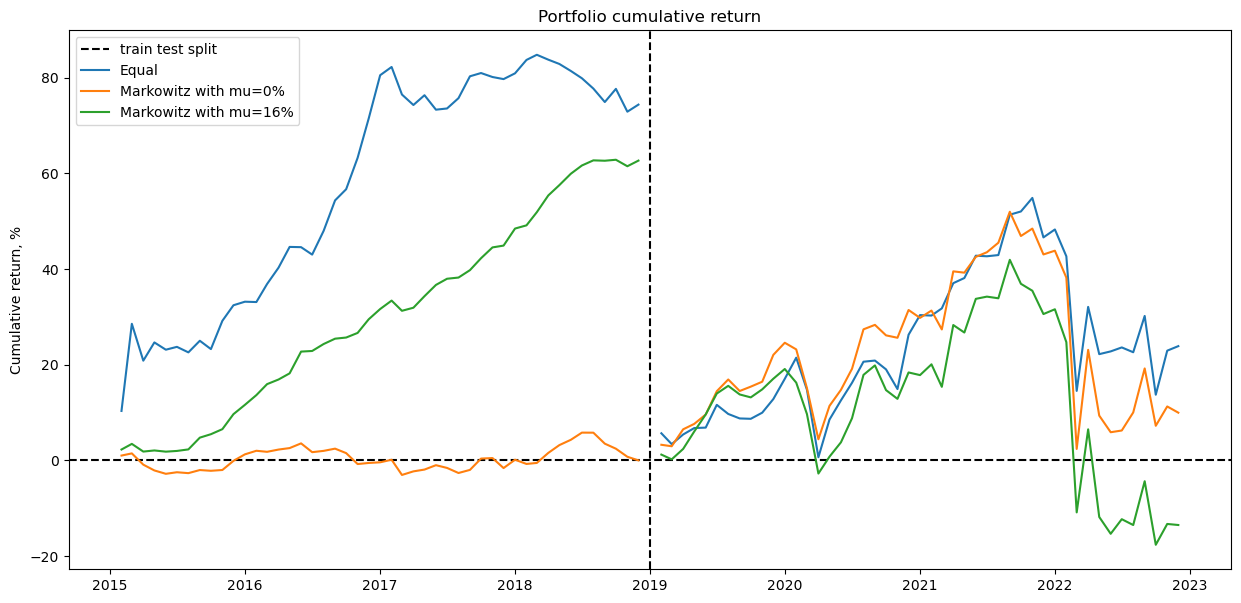

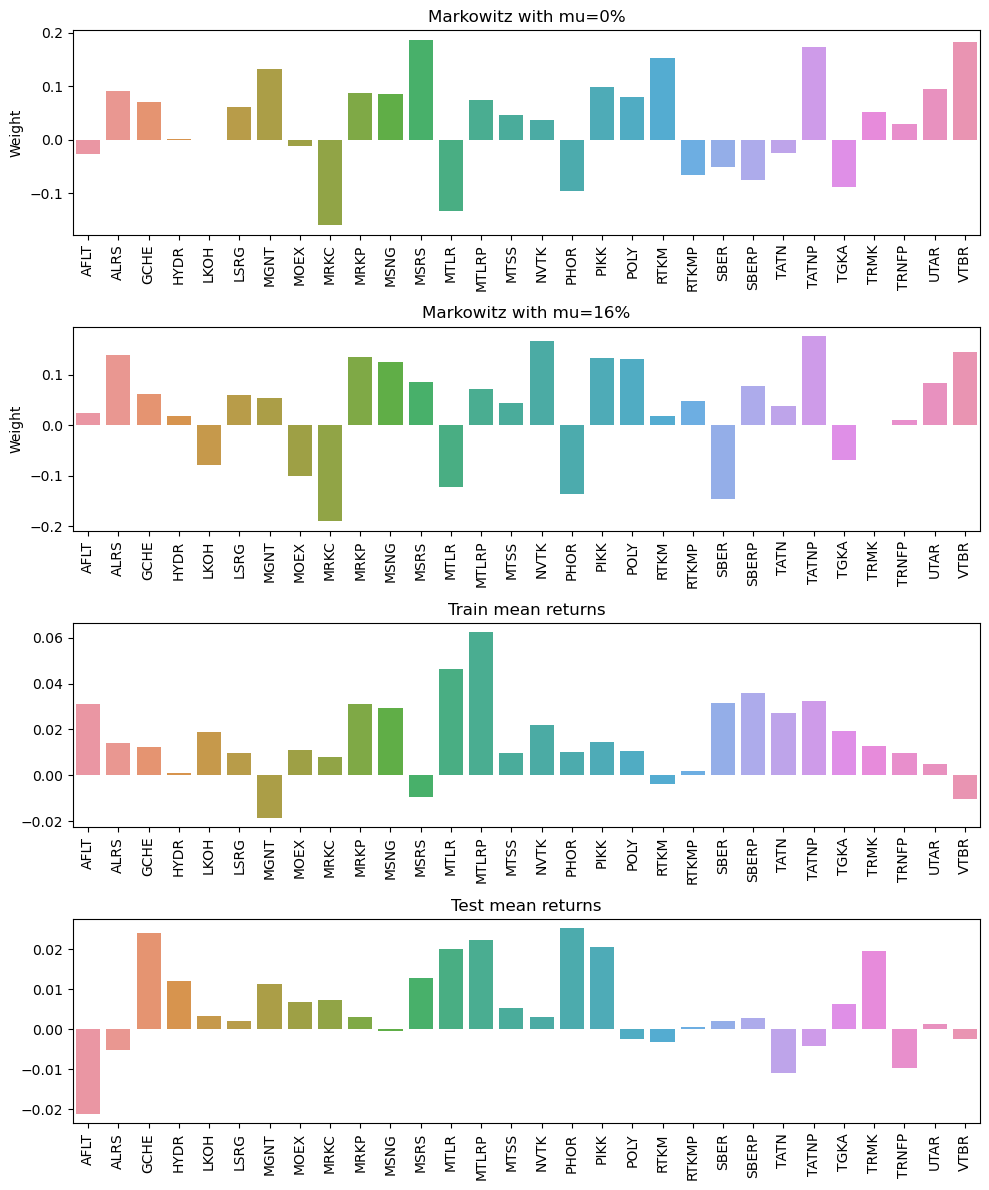

In [14]:
def markowitz(df_price: pd.DataFrame, mu: float, custom_sigma: pd.DataFrame | None = None) -> pd.Series:
    """
    mu is annual expected annual return in %
    """

    # convert mu to ratio return in 1 day
    mu = mu / 100 / TRADING_DAYS_IN_YEAR

    n_assets = len(df_price.columns)
    correlations = get_correlations(df_price_train)

    # construct linear equations
    returns = correlations.returns.values.mean(axis=0).reshape(-1, 1)
    stds = np.sqrt(np.diag(correlations.cov))
    sigma = correlations.cov.values if custom_sigma is None else stds.reshape(-1, 1) * custom_sigma * stds.reshape(1, -1)
    ones = np.ones((n_assets, 1))
    zeros = np.zeros((1, 1))
    X = np.block([[2 * sigma, -returns, -ones],
                  [returns.T, zeros, zeros],
                  [ones.T, zeros, zeros]])
    b = np.array([0.0] * n_assets + [mu, 1.0]).reshape(-1, 1)

    assert X.shape[0] == X.shape[1]
    assert X.shape[0] == n_assets + 2
    assert X.shape[0] == b.shape[0]

    # solve linear equations
    x = np.linalg.solve(X, b).reshape(-1)
    assert x.shape[0] == n_assets + 2

    # extract w, lambda_1, lambda_2 from solution
    w = x[:n_assets]
    w = pd.Series(w, df_price.columns)
    lambda_1 = x[n_assets]
    lambda_2 = x[n_assets + 1]

    assert np.isclose(w.sum(), 1.0)
    assert len(w.shape) == 1
    return w


mu_pct_year = 16

strategies = [
    Strategy(
        name='Markowitz with mu=0%',
        w=markowitz(df_price_train, 0.0)
    ),
    Strategy(
        name=f'Markowitz with mu={mu_pct_year}%',
        w=markowitz(df_price_train, mu_pct_year)
    )
]

compare_strategies(strategies, df_price_train, df_price_test)

# Remove market component from correlation matrix


In [15]:
correlations = get_correlations(df_price_train)
Sigma = correlations.corr

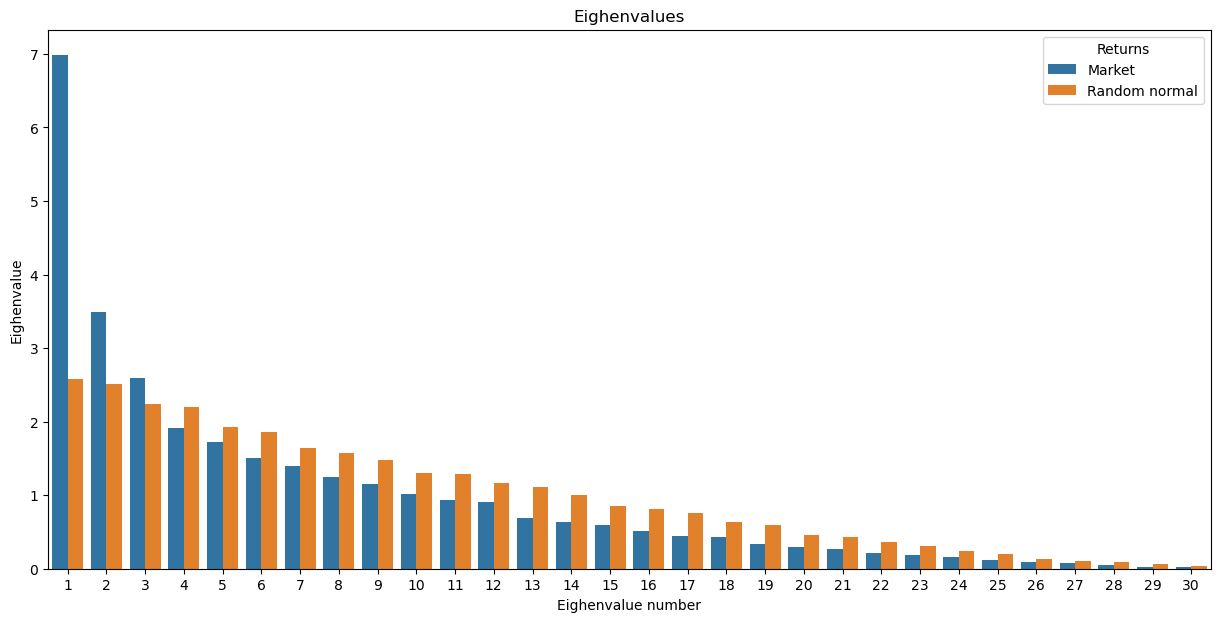

In [16]:
def plot_eighenvalues(Sigmas: list[pd.DataFrame], labels: list[pd.DataFrame]):
    S_for_Sigmas = pd.DataFrame(np.array([np.linalg.svd(Sigma)[1] for Sigma in Sigmas]).T, columns=labels)
    S_for_Sigmas['Id'] = np.arange(1, len(S_for_Sigmas) + 1)
    S_for_Sigmas = S_for_Sigmas.melt(id_vars='Id').rename(columns=str.title).rename(columns={'Variable': 'Returns'})

    plt.title('Eighenvalues')
    sns.barplot(S_for_Sigmas, x='Id', y='Value', hue='Returns')
    plt.gcf().set_figwidth(15)
    plt.gcf().set_figheight(7)
    plt.xlabel('Eighenvalue number')
    plt.ylabel('Eighenvalue')


plot_eighenvalues([Sigma, np.corrcoef(np.random.normal(size=correlations.returns.T.shape))], ['Market', 'Random normal'])

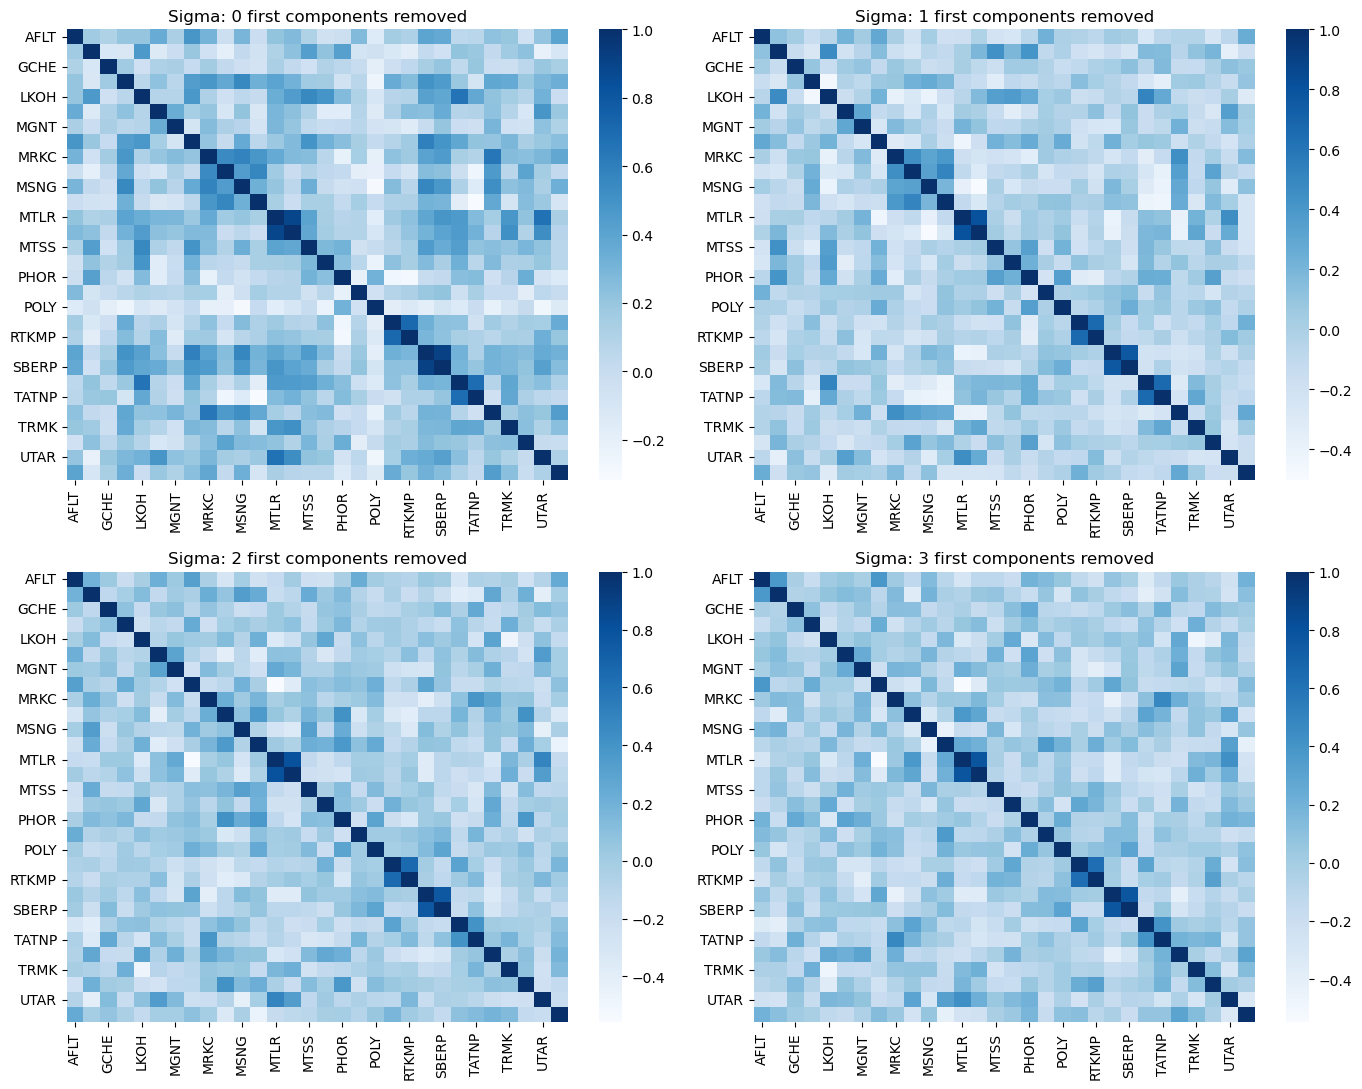

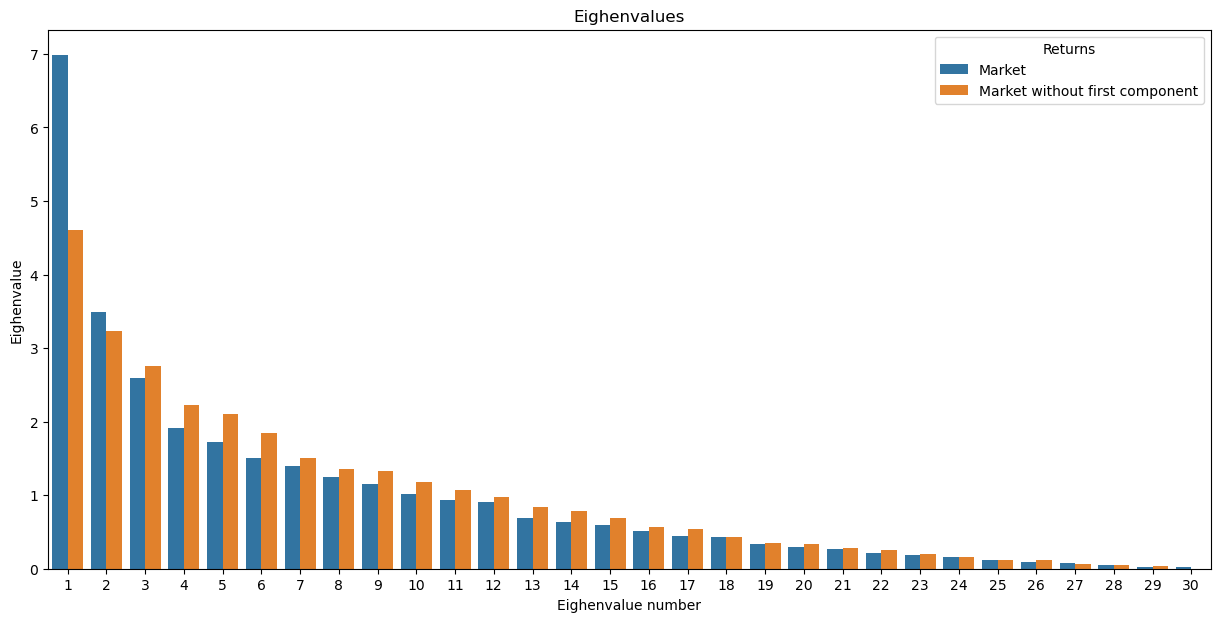

In [17]:
def reconstruct_from_svd(U, S, VT):
    return U * S @ VT


def normalize_correlation_matrix(Sigma):
    C = np.diag(Sigma) ** (-1/2)
    Sigma = C.reshape(-1, 1) * Sigma * C.reshape(1, -1)
    assert np.all(np.isclose(np.diag(Sigma), 1.0))
    return Sigma


def remove_market_component(Sigma: pd.DataFrame, n_removed_components: int = 1):
    assert np.all(np.isclose(Sigma, Sigma.T))
    U, S, VT = np.linalg.svd(Sigma)
    assert np.all(np.isclose(U, VT.T))
    assert np.all(np.isclose(U * S @ VT, Sigma))

    S[range(n_removed_components)] = 0
    Sigma_detoned = normalize_correlation_matrix(reconstruct_from_svd(U, S, VT))

    assert np.all(np.isclose(Sigma_detoned, Sigma_detoned.T))
    assert np.all(np.isclose(np.diag(Sigma_detoned), np.ones(Sigma_detoned.shape[0])))
    return pd.DataFrame(Sigma_detoned, columns=Sigma.columns, index=Sigma.index)


def plot_removed_market_component_sigma(Sigma: pd.DataFrame, max_removed_components: int):
    n = round(np.sqrt(max_removed_components))
    assert n ** 2 == max_removed_components
    plt.subplots(n, n, figsize=(14, 11))

    for i in range(max_removed_components):
        Sigma_detoned = remove_market_component(Sigma, n_removed_components=i)
        plt.subplot(n, n, i + 1)
        plt.title(f'Sigma: {i} first components removed')
        sns.heatmap(Sigma_detoned, cmap='Blues')
    plt.tight_layout()


plot_removed_market_component_sigma(Sigma, max_removed_components=4)
plt.show()
plot_eighenvalues([Sigma, remove_market_component(Sigma)], ['Market', 'Market without first component'])

# Remove noise from correlation matrix


T = 48. N = 30. c = 0.625


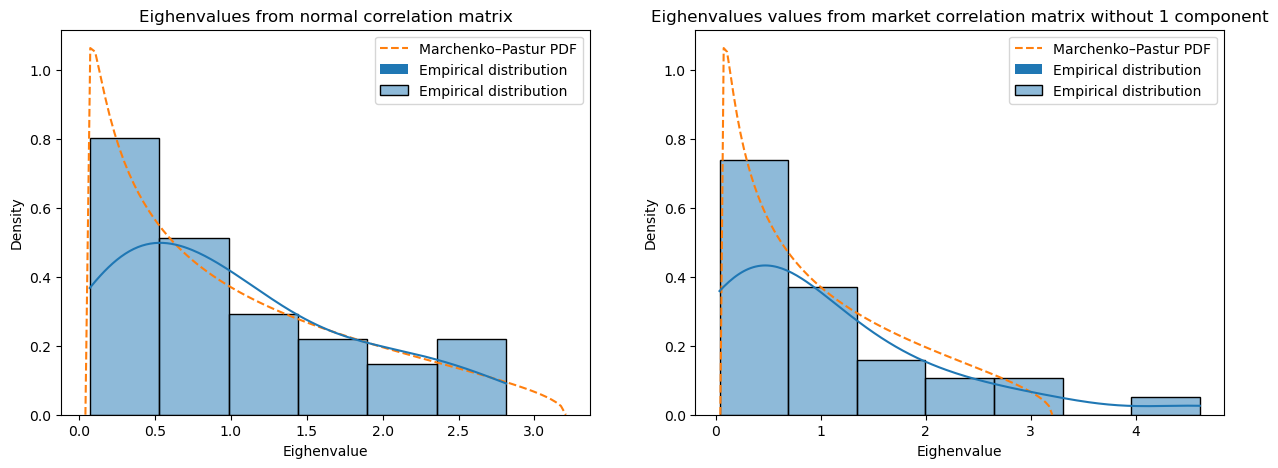

In [23]:
def get_marchenko_pastur_lambdas(sigma: float, c: float):
    assert 0 < c < 1

    lambda_minus = sigma ** 2 * (1 - np.sqrt(c)) ** 2
    lambda_plus = sigma ** 2 * (1 + np.sqrt(c)) ** 2

    return lambda_minus, lambda_plus


def marchenko_pastur_pdf(sigma: float, c: float, n_points: int) -> pd.Series:
    """
    # Marcenko-Pastur pdf
    # c = N / T in (0, 1)
    """
    lambda_minus, lambda_plus = get_marchenko_pastur_lambdas(sigma, c)
    lambda_ = np.linspace(lambda_minus, lambda_plus, n_points)

    pdf = np.sqrt((lambda_plus - lambda_) * (lambda_ - lambda_minus)) / (2 * np.pi * sigma ** 2 * c * lambda_)
    pdf = pd.Series(pdf, index=lambda_)

    return pdf


def plot_marchenko_pastur(df_price: pd.DataFrame, Sigma: pd.DataFrame, drop_zeros: bool = False):
    T, N = df_price.shape
    c = N / T
    # sigma = 1.0 for correlation matrix
    theory_pdf = marchenko_pastur_pdf(sigma=1.0, c=c, n_points=100)
    plt.plot(theory_pdf, color='C1', linestyle='dashed', label='Marchenko–Pastur PDF')

    # Plot the estimated density
    U, S, VT = np.linalg.svd(Sigma)
    if drop_zeros:
        S = S[~np.isclose(S, 0.0)]
    sns.histplot(S, stat='density', kde=True, label='Empirical distribution')
    plt.xlabel('Eighenvalue')
    plt.legend()


T, N = df_price_train.shape
c = N / T
print(f'{T = }. {N = }. {c = }')

plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Eighenvalues from normal correlation matrix')
plot_marchenko_pastur(df_price_train, np.corrcoef(np.random.normal(size=df_price_train.T.shape)))

plt.subplot(1, 2, 2)
plt.title('Eighenvalues values from market correlation matrix without 1 component')
plot_marchenko_pastur(df_price_train, remove_market_component(Sigma, n_removed_components=1), drop_zeros=True)
plt.show()

Remaining eighenvalues for denoised matrix: 2
Remaining eighenvalues for detoned and denoised matrix: 2


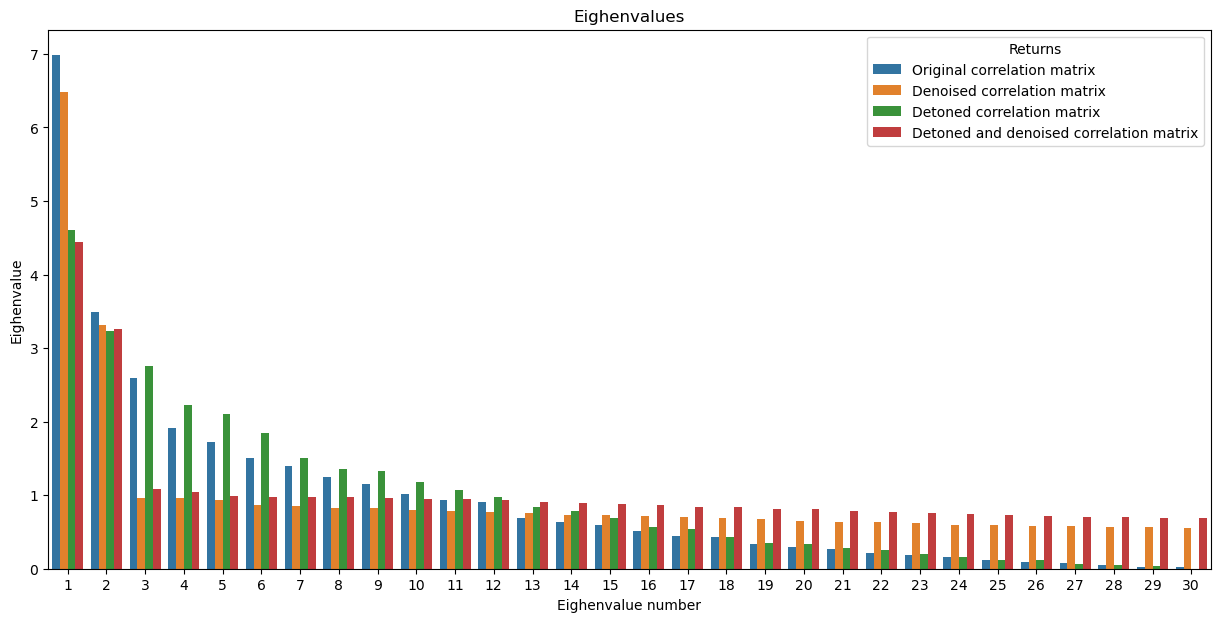

In [19]:
def remove_noise(df_price: pd.DataFrame, Sigma: pd.DataFrame) -> tuple[pd.DataFrame, int]:
    T, N = df_price.shape
    c = N / T
    lambda_minus, lambda_plus = get_marchenko_pastur_lambdas(sigma=1.0, c=c)
    U, S, VT = np.linalg.svd(Sigma)
    removed_values = (S < lambda_plus)
    remaining_values_count = len(S) - removed_values.sum()
    S[removed_values] = S[removed_values].mean()
    Sigma_denoised = normalize_correlation_matrix(reconstruct_from_svd(U, S, VT))
    return pd.DataFrame(Sigma_denoised, columns=Sigma.columns, index=Sigma.index), remaining_values_count


def denoise_and_detone(df_price: pd.DataFrame, Sigma: pd.DataFrame, n_removed_components=1) -> tuple[pd.DataFrame, int]:
    return remove_noise(df_price, remove_market_component(Sigma, n_removed_components=n_removed_components))


Sigma_detoned = remove_market_component(Sigma)

Sigma_denoised, remaining_denoised = remove_noise(df_price_train, Sigma)
print(f'Remaining eighenvalues for denoised matrix: {remaining_denoised}')

Sigma_detoned_denoised, remaining_detoned_denoised = denoise_and_detone(df_price_train, Sigma)
print(f'Remaining eighenvalues for detoned and denoised matrix: {remaining_detoned_denoised}')

plot_eighenvalues([Sigma, Sigma_denoised, Sigma_detoned, Sigma_detoned_denoised],
                  ['Original correlation matrix', 'Denoised correlation matrix', 'Detoned correlation matrix', 'Detoned and denoised correlation matrix'])

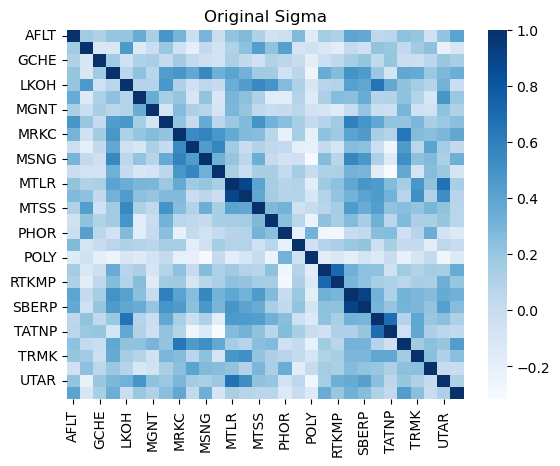

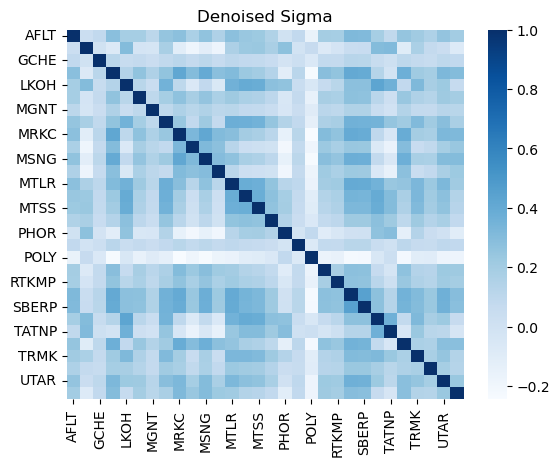

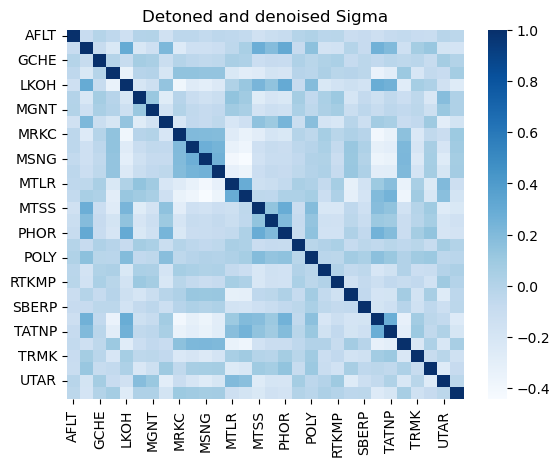

In [20]:
plt.title('Original Sigma')
sns.heatmap(Sigma, cmap='Blues')
plt.show()

plt.title('Denoised Sigma')
sns.heatmap(Sigma_denoised, cmap='Blues')
plt.show()

plt.title('Detoned and denoised Sigma')
sns.heatmap(Sigma_detoned_denoised, cmap='Blues')
plt.show()

Markowitz with mu=18% (original)
                   portfolio_train   baseline_train    portfolio_test   baseline_test
return              18.00% ± 4.79%  18.99% ± 15.39%   -4.20% ± 28.52%  6.10% ± 25.42%
sharpe ratio              3.755744         1.234087          -0.14718        0.239921
difference         -0.99% ± 14.59%    0.00% ± 0.00%  -10.30% ± 12.50%   0.00% ± 0.00%
information ratio        -0.067712              NaN         -0.823528             NaN

Markowitz with mu=18% (denoised)
                   portfolio_train   baseline_train   portfolio_test   baseline_test
return              18.00% ± 8.51%  18.99% ± 15.39%   4.27% ± 22.19%  6.10% ± 25.42%
sharpe ratio              2.114624         1.234087         0.192389        0.239921
difference         -0.99% ± 14.01%    0.00% ± 0.00%  -1.83% ± 11.04%   0.00% ± 0.00%
information ratio        -0.070552              NaN         -0.16559             NaN

Markowitz with mu=18% (detoned)
                   portfolio_train   baseline

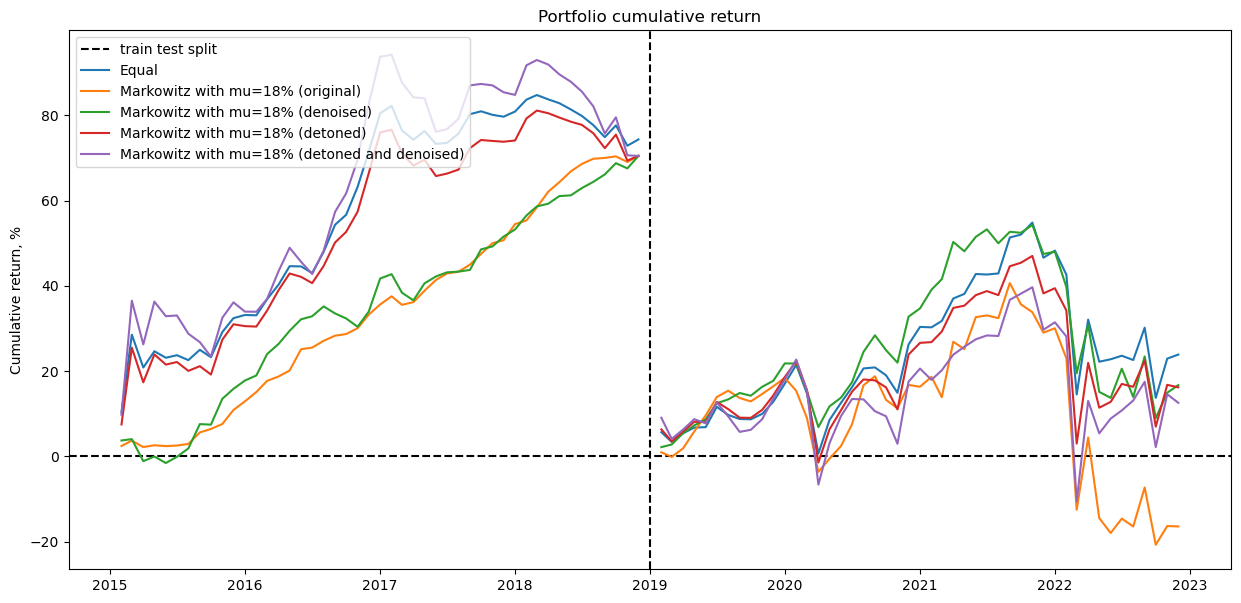

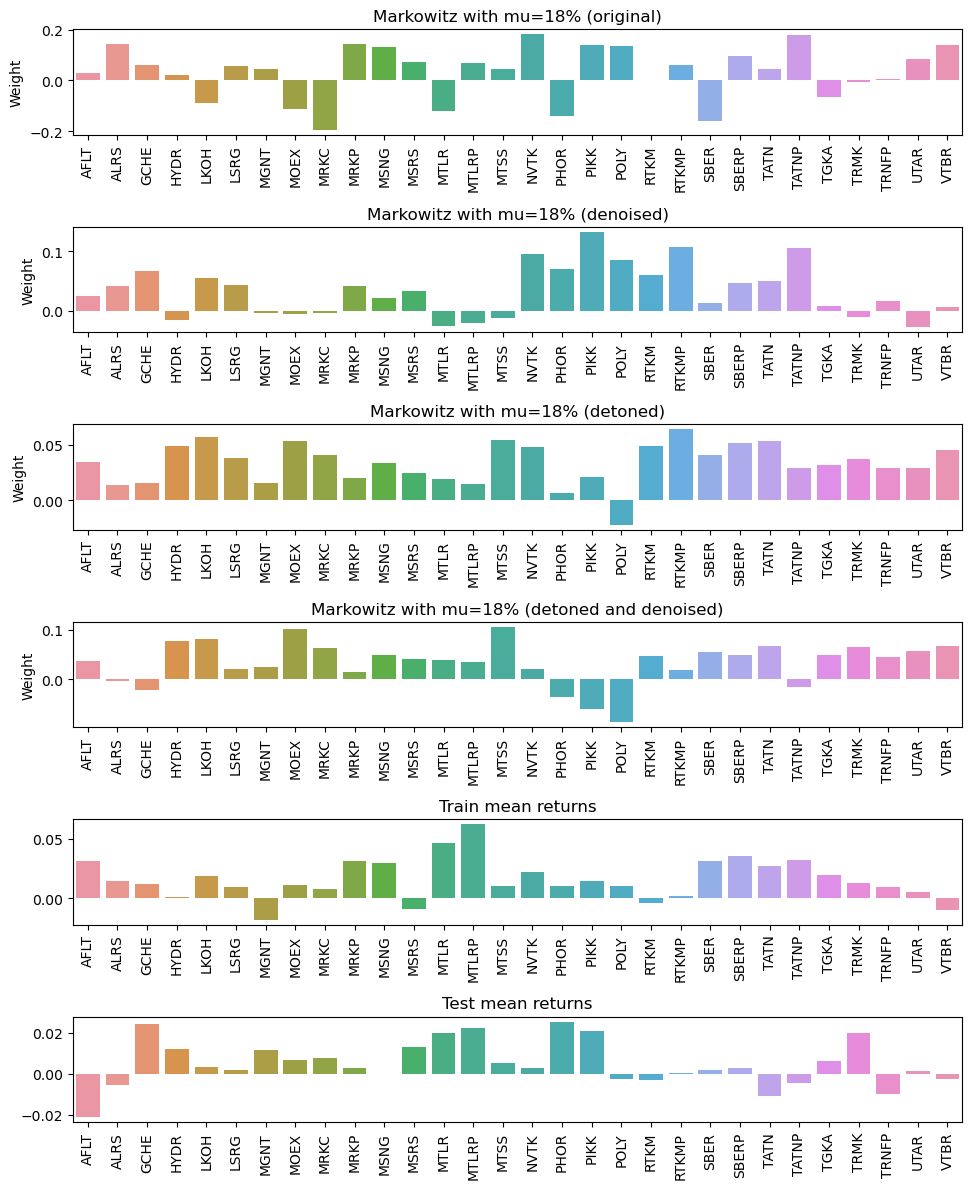

In [21]:
mu_pct_year = 18

strategies = [
    Strategy(
        name=f'Markowitz with mu={mu_pct_year}% (original)',
        w=markowitz(df_price_train, mu_pct_year)
    ),
    Strategy(
        name=f'Markowitz with mu={mu_pct_year}% (denoised)',
        w=markowitz(df_price_train, mu_pct_year, Sigma_denoised)
    ),
    Strategy(
        name=f'Markowitz with mu={mu_pct_year}% (detoned)',
        w=markowitz(df_price_train, mu_pct_year, Sigma_detoned)
    ),
    Strategy(
        name=f'Markowitz with mu={mu_pct_year}% (detoned and denoised)',
        w=markowitz(df_price_train, mu_pct_year, Sigma_detoned_denoised)
    )
]

compare_strategies(strategies, df_price_train, df_price_test)